### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут  
$c_k, f_k = argmin_{c, k} \sum\limits_{i=1}^N L(F_{k-1}(x_i) + c f(x_i), y_i)$  
$f_k(x_i) \approx - \frac{\partial L(x, y)}{\partial x}$  
1) MSE  
$$f_k(x_i) = - \frac{\partial (y_i - a) ^ 2}{\partial a} = 2 (y_i - a)\bigg|_{a = F_{k-1}(x_i)} = 2 (y_i - F_{k-1}(x_i))$$   
2) Экспоненциальная функция потерь  
$$f_k(x_i) = - \frac{\partial e^{-a y_i}}{\partial a} = y_i e^{-a y_i}\bigg|_{a = F_{k-1}(x_i)} = y_i e^{-F_{k-1}(x_i) y_i}$$  
3) Логистическая функция потерь  
$$f_k(x_i) = - \frac{\partial \log (1 + e^{-a y_i})}{\partial a} = \frac{y_i e^{-a y_i}}{1 + e^{-a y_i}} = \frac{y_i}{1 + e^{a y_i}}\bigg|_{a = F_{k-1}(x_i)} = \frac{y_i}{1 + e^{F_{k-1}(x_i) y_i}}$$ 

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import sklearn

In [2]:
from numpy.random import default_rng

np.random.seed(40)
rng = default_rng()

In [3]:
class MyGradientBoostingClassifier:

    def __init__(self,
                 loss = 'mse',
                 learning_rate = 0.1,
                 n_estimators = 100,
                 colsample = 1.0,
                 subsample = 1.0,
                 *args,
                 **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        
        if not (loss in ['mse', 'exp_loss', 'log_loss']):
            raise ValueError
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        
        self.model = None
        self.first_model = None

        self.features_idx = []
        self.models = []
        self.coef = []
    
    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        
        self.features_idx = []
        self.models = []
        self.coef = []

        data = np.array(X)
        target = np.array(y)
        self.model = base_model

        if init_model:
            first_model = init_model()
            first_model.fit(data, target)
            self.features_idx.append(np.arange(data.shape[1]))
            self.models.append(first_model)
            self.coef.append(1)
        
        for _ in range(self.n_estimators):
            
            pred = self.predict(data)
            
            target_1 = None
            if self.loss == 'mse':
                target_1 = 2 * (target - pred)
            elif self.loss == 'exp_loss':
                target_1 = target * np.exp(-pred * target)
            elif self.loss == 'log_loss':
                target_1 = target / (1 + np.exp(pred * target))

            samples_idx =  default_rng().choice(data.shape[0], size=round(self.subsample * data.shape[0]), replace=False)
            features_idx =  default_rng().choice(data.shape[1], size=round(self.subsample * data.shape[1]), replace=False)

            model = base_model(*self.args, **self.kwargs)
            model.fit(data[samples_idx, :][:, features_idx], target_1[samples_idx])
            self.features_idx.append(features_idx)
            self.models.append(model)

        return self
        
    def predict(self, X):
        # Ваш код здесь
        pred = np.zeros(X.shape[0])
        for base_model, idx in zip(self.models, self.features_idx):
            pred += self.learning_rate * base_model.predict(X[:, idx])
        pred = np.round(pred).astype(int)
        return pred

In [4]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [5]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [6]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

##### Построить график точности в зависимости от числа итераций на валидации

In [10]:
estimators_list = [3, 6, 10, 30, 50, 70, 100, 150, 200, 350, 500, 750, 1000]
accuracy_list = []
for n_estimators in estimators_list:
    my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators)
    my_clf.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(my_clf.predict(X_test), y_test))

best_n_estimators = estimators_list[np.argmax(accuracy_list)]

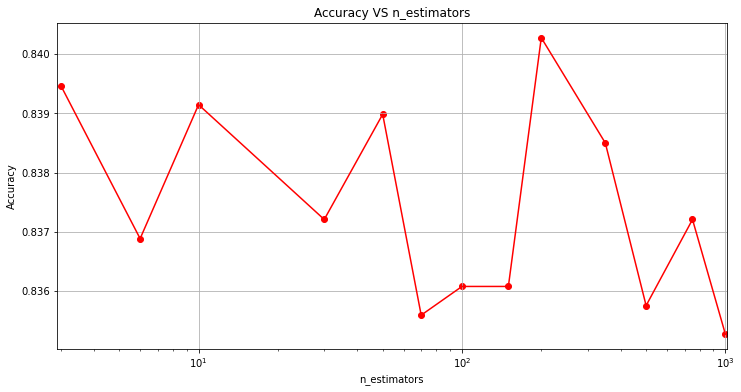

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(estimators_list, accuracy_list, 'red')
plt.scatter(estimators_list, accuracy_list, c='red')
plt.title('Accuracy VS n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xlim([2.9, 1010])
plt.grid(True)
plt.show()

##### Подобрать оптимальные параметры бустинга на валидации

In [12]:
best_params = {'n_estimators': best_n_estimators}

In [13]:
loss_list = ['mse', 'exp_loss', 'log_loss']
accuracy_list = []
for loss in loss_list:
    my_clf = MyGradientBoostingClassifier(**best_params, loss=loss)
    my_clf.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(my_clf.predict(X_test), y_test))

best_params['loss'] = loss_list[np.argmax(accuracy_list)]

In [14]:
learning_rate_list = [0.0001, 0.001, 0.01, 0.1, 1]
accuracy_list = []
for lr in learning_rate_list:
    my_clf = MyGradientBoostingClassifier(**best_params, learning_rate=lr)
    my_clf.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(my_clf.predict(X_test), y_test))

best_params['learning_rate'] = learning_rate_list[np.argmax(accuracy_list)]

In [15]:
colsample_list = [0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
accuracy_list = []
for cs in colsample_list:
    my_clf = MyGradientBoostingClassifier(**best_params, colsample=cs)
    my_clf.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(my_clf.predict(X_test), y_test))

best_params['colsample'] = colsample_list[np.argmax(accuracy_list)]

In [16]:
subsample_list = [0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
accuracy_list = []
for subs in colsample_list:
    my_clf = MyGradientBoostingClassifier(**best_params, subsample=subs)
    my_clf.fit(X_train, y_train)
    accuracy_list.append(accuracy_score(my_clf.predict(X_test), y_test))

best_params['subsample'] = subsample_list[np.argmax(accuracy_list)]

In [17]:
# модель с лучшими параметрами
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train)
accuracy_score(my_clf.predict(X_test), y_test)

0.8367248062015504

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [18]:
# GradientBoosting
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train)
accuracy_score(my_clf.predict(X_test), y_test)

0.8383397932816538

In [19]:
# BooBag
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X_train, y_train, sklearn.ensemble.RandomForestClassifier)
accuracy_score(my_clf.predict(X_test), y_test)

0.8840439276485789

In [20]:
# BagBoo
N = 7
preds = np.zeros(X_test.shape[0])
subsample_size = round(0.7 * X_train.shape[0])
for _ in range(N):
    samples_idx = rng.choice(X_train.shape[0], subsample_size, replace=False)
    my_clf = MyGradientBoostingClassifier()
    my_clf.fit(X_train[samples_idx, :], y_train[samples_idx])
    preds += my_clf.predict(X_test)

y_pred = np.round(preds / N)
accuracy_score(y_pred, y_test)

0.8662790697674418

Ура! Качество улучшилось!

В первом случае мы использовали более мощную базовую модель, которая даёт лучшее качество, чем решающее дерево, следовательно, итоговый алгоритм также даёт лучший результат.  
Во втором случае мы избегаем переобучения и компенсируем отклонения одной модели отклонениями другой, обученной на других данных, следовательно, дисперсия усредненной модели уменьшается.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [21]:
from functools import partial

log_reg = partial(sklearn.linear_model.LogisticRegression, max_iter=1000)
svm_reg = partial(sklearn.svm.LinearSVC, max_iter=10000, C=1e-7)

In [22]:
my_clf = MyGradientBoostingClassifier()

my_clf.fit(X_train, y_train, init_model = sklearn.ensemble.RandomForestClassifier)
print("GB with RandomForest: AC =", accuracy_score(my_clf.predict(X_test), y_test))

my_clf.fit(X_train, y_train, init_model = sklearn.neighbors.KNeighborsClassifier)
print("GB with KNeighbors: AC =", accuracy_score(my_clf.predict(X_test), y_test))

my_clf.fit(X_train, y_train, init_model = log_reg)
print("GB with LogisticRegression: AC =", accuracy_score(my_clf.predict(X_test), y_test))

my_clf.fit(X_train, y_train, init_model = svm_reg)
print("GB with SVM: AC =", accuracy_score(my_clf.predict(X_test), y_test))

GB with RandomForest: AC = 0.835594315245478
GB with KNeighbors: AC = 0.834625322997416
GB with LogisticRegression: AC = 0.8383397932816538
GB with SVM: AC = 0.8376937984496124


Качество незначительно изменяется, все алгоритмы в итоге дают примерно одинаковые результаты, сопоставимые с результатами инициализации нулевой константой.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

